In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Load the serialized model
model = keras.models.load_model("my_model.keras")

#The loaded model is then ready to receive data and make predictions using
predictions = model.predict(input_data)

In [20]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42
DATA_DIR = 'C:\\Users\\Specter\\Desktop\\Friontier ML training\\capstone_project\\code\\PlantVillage'

##  Split the Dataset into training, testing and validation 

In [21]:
# Load and split the data using 80% train, 10% val, 10% test
full_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    label_mode='categorical'  # For multi-class classification
)

Found 20638 files belonging to 15 classes.


In [22]:
# Calculate split sizes
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Use dataset.take and dataset.skip to split
train_data = full_dataset.take(train_size)
val_test_data = full_dataset.skip(train_size)
val_data = val_test_data.take(val_size)
test_data = val_test_data.skip(val_size)

In [30]:
import tensorflow as tf

test_sample_count = 0
for images, labels in test_data:
    #print(f"Batch image shape: {images.shape}, Batch label shape: {labels.shape}")
    test_sample_count += images.shape[0]

print(f"\nTotal number of test samples: {test_sample_count}")



Total number of test samples: 2078


## Apply Augmentations Only to Training Set

In [5]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

AUTOTUNE = tf.data.AUTOTUNE

def augment(ds):
    return ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)

train_data = augment(train_data)

# Prefetch for performance
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [6]:
class_names = full_dataset.class_names
num_classes = len(class_names)

In [7]:
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [8]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


## Train the Model

In [9]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1687s 3s/step - accuracy: 0.5431 - loss: 1.5294 - val_accuracy: 0.8418 - val_loss: 0.6106
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1360s 3s/step - accuracy: 0.8213 - loss: 0.6197 - val_accuracy: 0.8647 - val_loss: 0.4663
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 663s 1s/step - accuracy: 0.8419 - loss: 0.5133 - val_accuracy: 0.8765 - val_loss: 0.4052
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 644s 1s/step - accuracy: 0.8555 - loss: 0.4589 - val_accuracy: 0.8789 - val_loss: 0.3874
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 683s 1s/step - accuracy: 0.8623 - loss: 0.4342 - val_accuracy: 0.8872 - val_loss: 0.3545
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 687s 1s/step - accuracy: 0.8640 - loss: 0.4069 - val_accuracy: 0.8931 - val_loss: 0.3408
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 641s 1s/step - accuracy: 0.8668 - loss: 0.4089 - val_accuracy: 0.9023 - val_loss: 0.3112
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 702s 1s/step - accuracy: 0.8773 - loss: 0.3752 - val_ac

## Evaluate the Model

In [10]:
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

65/65 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8990 - loss: 0.2694 
Test Accuracy: 90.28%


## Classification Report

In [15]:
# Get predictions
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from the test_data
y_true = []
for _, labels in test_data.unbatch():
    y_true.append(np.argmax(labels.numpy()))
y_true = np.array(y_true)

# Get class labels from earlier
class_labels = class_names  # already extracted from full_dataset.class_names

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


65/65 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step 
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.05      0.05      0.05        96
                     Pepper__bell___healthy       0.06      0.06      0.06       148
                      Potato___Early_blight       0.01      0.01      0.01        99
                       Potato___Late_blight       0.02      0.02      0.02        93
                           Potato___healthy       0.00      0.00      0.00        16
                      Tomato_Bacterial_spot       0.12      0.10      0.11       228
                        Tomato_Early_blight       0.03      0.02      0.02       105
                         Tomato_Late_blight       0.09      0.09      0.09       195
                           Tomato_Leaf_Mold       0.05      0.04      0.05        90
                  Tomato_Septoria_leaf_spot       0.12      0.13      0.13       193
Tomato_Spider_mites_Two_

## Confusion Matrix

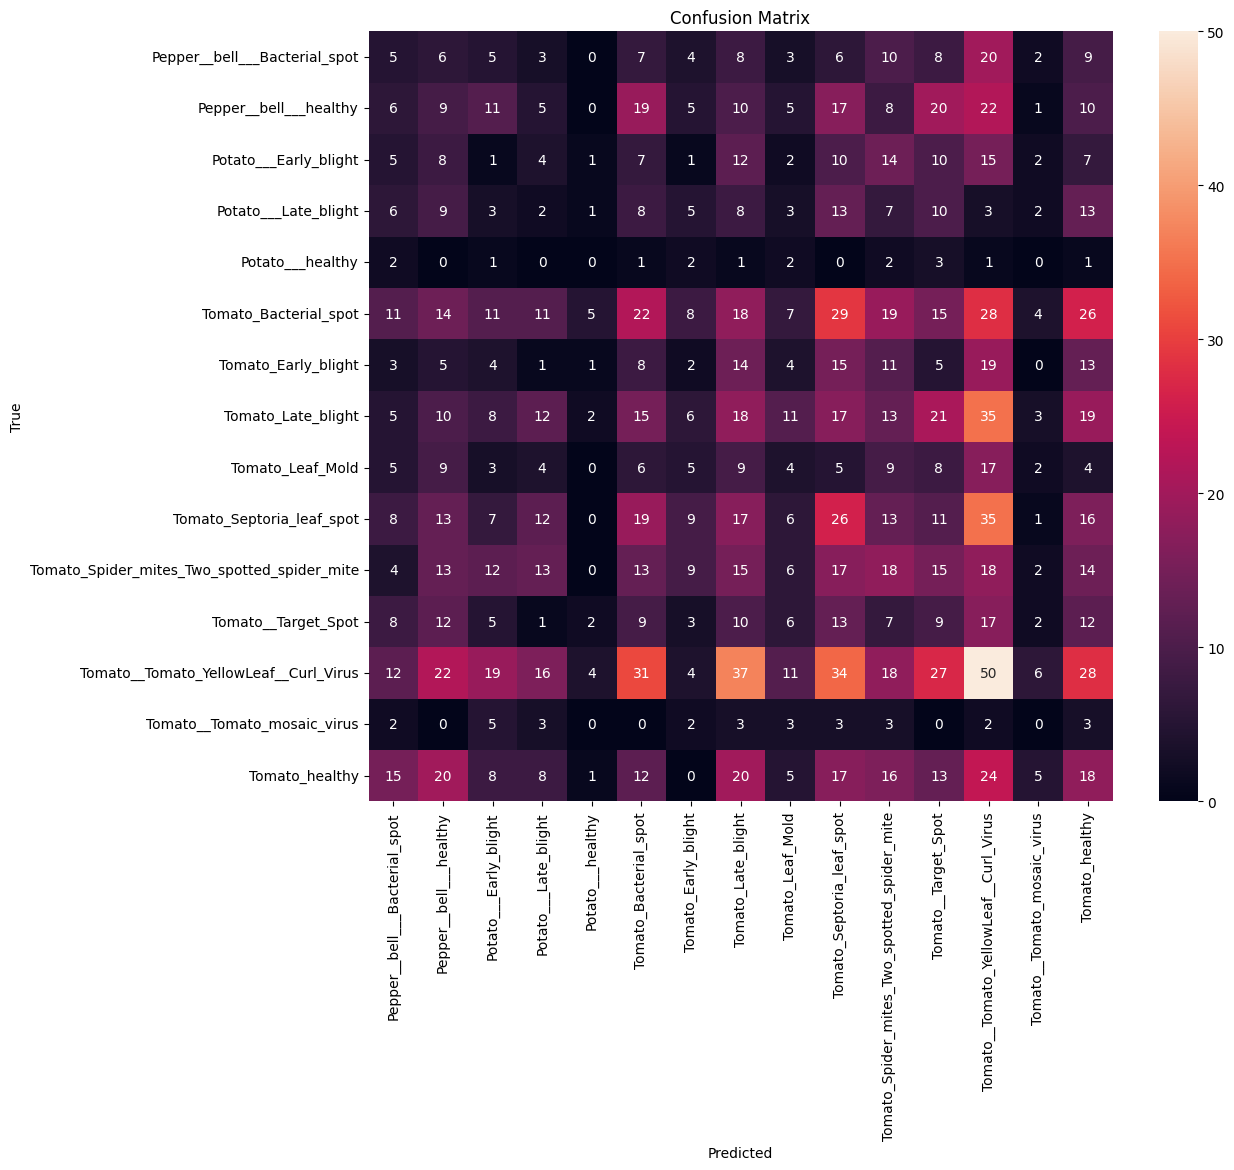

In [17]:
import seaborn as sns
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Save the Model

In [20]:
model.save("plant_disease_detector1.h5")

In [18]:
#from keras.saving import save_model
#save_model(model, "plant_disease_detector2.keras")

model.save("plant_disease_detector3.keras", include_optimizer=False)


In [9]:
def build_model(hp):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False  # Keep frozen during tuning

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    # Tune number of dense units
    units = hp.Int('units', min_value=64, max_value=512, step=64)
    x = layers.Dense(units, activation='relu')(x)

    # Tune dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
    x = layers.Dropout(dropout_rate)(x)

    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [13]:
from tensorflow.keras import layers

In [11]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner_logs',
    project_name='plant_disease'
)

Reloading Tuner from tuner_logs\plant_disease\tuner0.json


## Search for Best Hyperparameters

In [12]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(train_data, validation_data=val_data, epochs=10, callbacks=[stop_early])


Trial 17 Complete [01h 48m 58s]
val_accuracy: 0.93798828125

Best val_accuracy So Far: 0.93798828125
Total elapsed time: 1d 01h 55m 51s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
384               |448               |units
0.4               |0.4               |dropout_rate
0.001             |0.001             |learning_rate
10                |10                |tuner/epochs
4                 |4                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |2                 |tuner/round
0015              |0013              |tuner/trial_id

Epoch 5/10
218/516 ━━━━━━━━━━━━━━━━━━━━ 12:12 2s/step - accuracy: 0.9271 - loss: 0.2219

KeyboardInterrupt: 

## Retrieve and Train Best Model

In [12]:
# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best dropout rate: {best_hps.get('dropout_rate')}")
print(f"Best dense units: {best_hps.get('units')}")

Best learning rate: 0.001
Best dropout rate: 0.4
Best dense units: 448


In [10]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner_logs',          # <--- this is the save location
    project_name='plant_disease'     # <--- this is the sub-folder name
)


Reloading Tuner from tuner_logs\plant_disease\tuner0.json


In [14]:
import keras_tuner as kt

# 1. Recreate the same tuner instance (no need to search again)
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner_logs',
    project_name='plant_disease'
)

# 2. Load best hyperparameters from saved logs
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# 3. Rebuild the best model using the loaded hyperparameters
model = tuner.hypermodel.build(best_hps)


Reloading Tuner from tuner_logs\plant_disease\tuner0.json


In [14]:
# Build model with best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1409s 3s/step - accuracy: 0.7039 - loss: 0.9455 - val_accuracy: 0.8784 - val_loss: 0.3453
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1376s 3s/step - accuracy: 0.8837 - loss: 0.3434 - val_accuracy: 0.8931 - val_loss: 0.2959
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1476s 3s/step - accuracy: 0.9105 - loss: 0.2660 - val_accuracy: 0.8755 - val_loss: 0.3380
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1431s 3s/step - accuracy: 0.9236 - loss: 0.2230 - val_accuracy: 0.9253 - val_loss: 0.2114
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 3043s 6s/step - accuracy: 0.9240 - loss: 0.2219 - val_accuracy: 0.9131 - val_loss: 0.2443
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - accuracy: 0.9323 - loss: 0.1896 - val_accuracy: 0.9390 - val_loss: 0.1730
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 692s 1s/step - accuracy: 0.9309 - loss: 0.1887 - val_accuracy: 0.9482 - val_loss: 0.1416
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.9448 - loss: 0.1676 - val

### Evaluate Model on Validation/Test Set

In [16]:
# Evaluate accuracy and loss
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9356 - loss: 0.1849 
Validation Accuracy: 0.9360
Validation Loss: 0.1773


In [17]:
# Save model in .keras format (recommended for newer Keras versions)
model.save("plant_disease_best_model.keras")

## Generate Classification Report & Confusion Matrix

In [22]:
val_data = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32
)

Found 20638 files belonging to 15 classes.


In [23]:
class_names = val_data.class_names

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

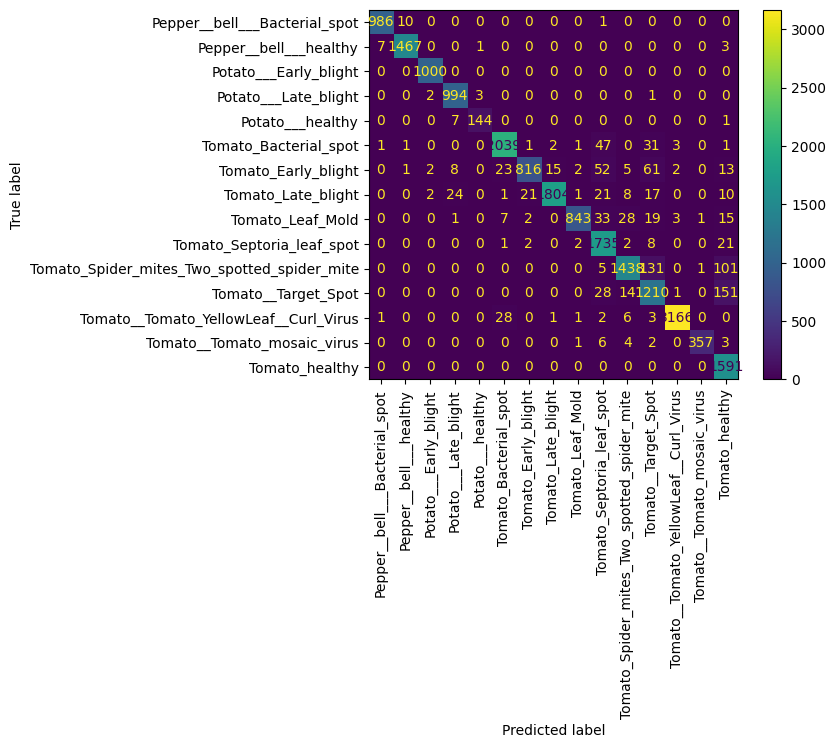

In [25]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Assuming val_data is from image_dataset_from_directory
class_names = val_data.class_names

# Get predictions
y_true = []
y_pred = []

for images, labels in val_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())  
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation='vertical')

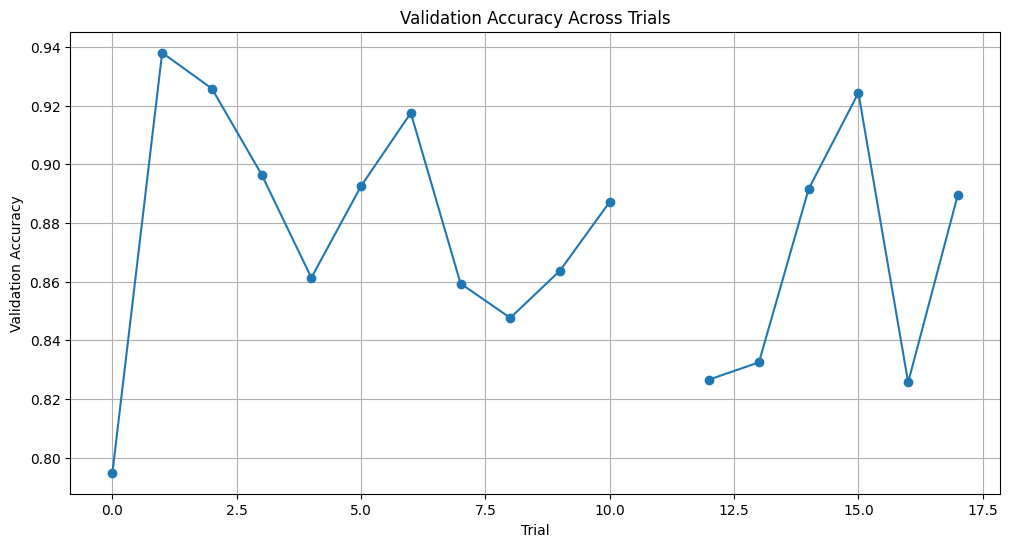

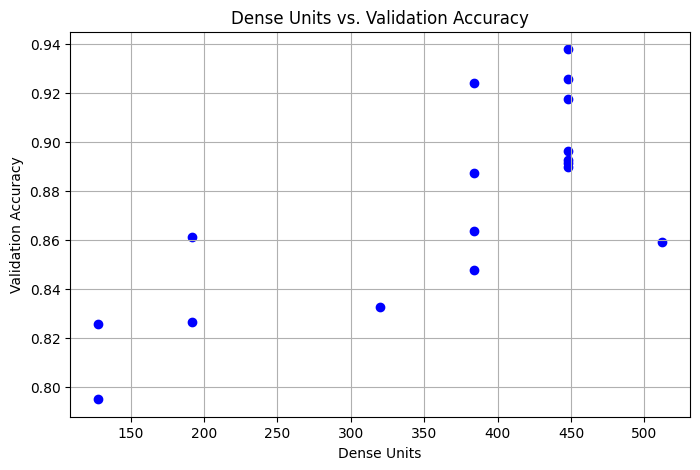

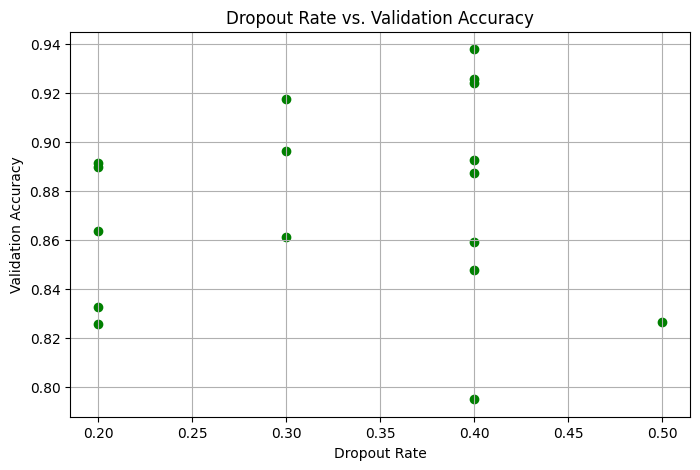

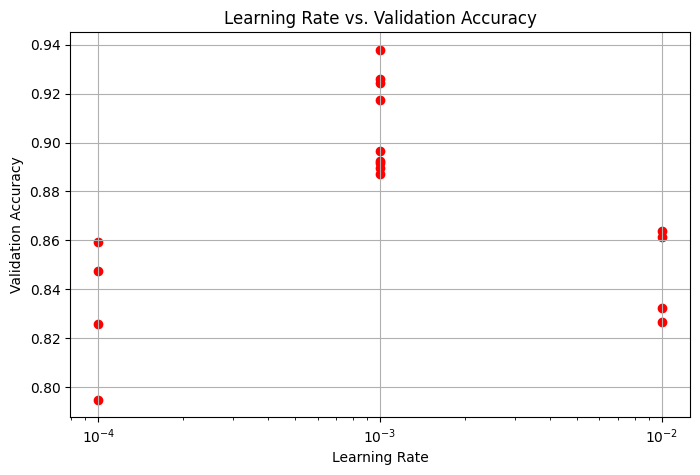

In [18]:
# Get all trials from the tuner
tuner_results = tuner.oracle.trials.values()

# Extract data into a list of dictionaries
data = []
for trial in tuner_results:
    hp_values = trial.hyperparameters.values
    data.append({
        "trial_id": trial.trial_id,
        "val_accuracy": trial.score,
        "units": hp_values.get("units", None),
        "dropout_rate": hp_values.get("dropout_rate", None),
        "learning_rate": hp_values.get("learning_rate", None),
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot validation accuracy across trials
plt.figure(figsize=(12, 6))
plt.plot(df['val_accuracy'], marker='o')
plt.title("Validation Accuracy Across Trials")
plt.xlabel("Trial")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

# Scatter plot: Dense Units vs Validation Accuracy
plt.figure(figsize=(8, 5))
plt.scatter(df["units"], df["val_accuracy"], c='blue')
plt.title("Dense Units vs. Validation Accuracy")
plt.xlabel("Dense Units")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

# Scatter plot: Dropout Rate vs Validation Accuracy
plt.figure(figsize=(8, 5))
plt.scatter(df["dropout_rate"], df["val_accuracy"], c='green')
plt.title("Dropout Rate vs. Validation Accuracy")
plt.xlabel("Dropout Rate")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

# Scatter plot: Learning Rate vs Validation Accuracy
plt.figure(figsize=(8, 5))
plt.scatter(df["learning_rate"], df["val_accuracy"], c='red')
plt.title("Learning Rate vs. Validation Accuracy")
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.xscale('log')  # Log scale for LR
plt.grid(True)
plt.show()


In [31]:
from tensorflow.keras.models import load_model

model = load_model('plant_disease_best_model.keras')  # or .keras file
#model.save("plant_disease_best_model.keras")

In [46]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42
test_data2 = 'C:\\Users\\Specter\\Desktop\\Friontier ML training\\capstone_project\\code\\data\\test_data'

In [47]:
# Step 2: Create the test dataset
test_data = tf.keras.utils.image_dataset_from_directory(
    test_data2,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False
)

# Step 3: Access class names
class_names = test_data.class_names
num_classes = len(class_names)

Found 239 files belonging to 15 classes.


In [48]:
class_names = test_data.class_names
num_classes = len(class_names)

In [49]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_pred.extend(predicted_classes)
    y_true.extend(labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00        13
                     Pepper__bell___healthy       1.00      1.00      1.00        17
                      Potato___Early_blight       1.00      1.00      1.00        14
                       Potato___Late_blight       0.83      1.00      0.91        15
                           Potato___healthy       1.00      0.94      0.97        16
                      Tomato_Bacterial_spot       1.00      0.88      0.93        16
                        Tomato_Early_blight       0.92      0.75      0.83        16
                         Tomato_Late_blight       0.94      0.88      0.91        17
                           Tomato_Leaf_Mold       0.94      0.88      0.91        17
                  Tomato_Septoria_leaf_spot       0.94      1.00      0.97        17
Tomato_Spider_mites_Two_spotted_spider_mite       0.94      0.88

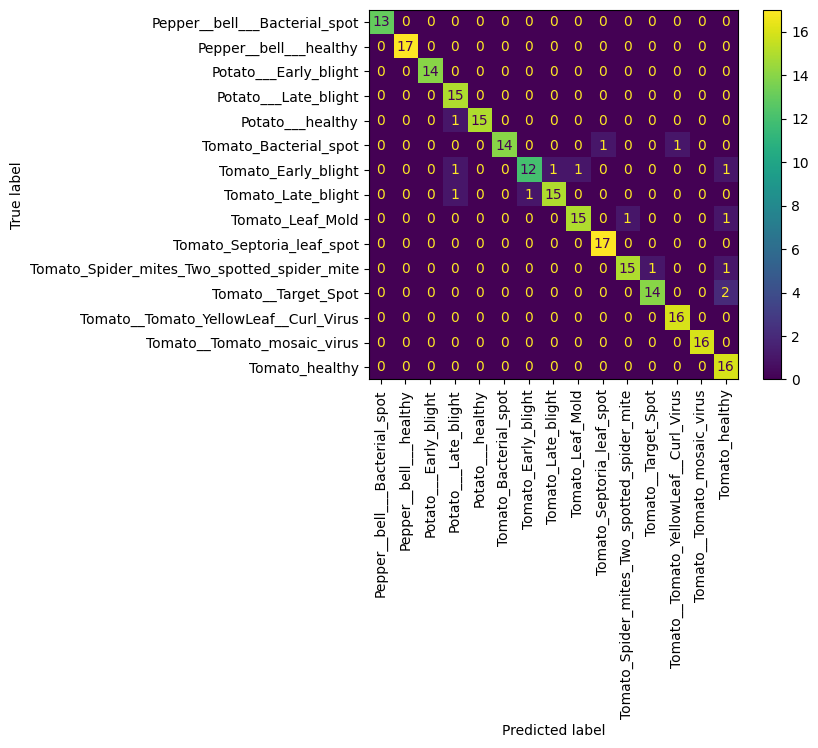

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_true, y_pred, target_names=test_data.class_names))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.class_names)
disp.plot(xticks_rotation='vertical')
